In [1]:
    # import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from tqdm import tqdm

In [2]:
# Define the class of traditional item based collaborative filtering
class ItemBasedCF:
    def __init__(self, filepath, k=20, n=10):
        self.filepath = filepath
        self.k = k
        self.n = n
        self.data = self.load_data()
        self.train_data, self.test_data = self.split_data()
        self.item_sim_mat = self.cal_sim_mat()
        self.recommendation = self.recommend()


    # load data
    def load_data(self):
        print("加载数据...")
        rating = pd.read_csv(self.filepath)
        train_dict = rating.iloc[:,:3].to_dict('split')
        data = train_dict['data']
        return data

    # split data
    def split_data(self):
        print("分割数据...")
        train_data = {}
        test_data = {}
        # control the random seed
        np.random.seed(1)
        for user, item, rating in self.data:
            if np.random.rand() < 0.8:
                if user not in train_data:
                    train_data[user] = {}
                train_data[user][item] = rating
            else:
                if user not in test_data:
                    test_data[user] = {}
                test_data[user][item] = rating
        return train_data, test_data

    # calculate item similarity matrix
    def cal_sim_mat(self):
        # print("计算物品相似度矩阵...")
        # if os.path.exists("data/ibf_item_sim_mat.pkl"):
        #     print("从文件中加载物品相似度矩阵...")
        #     item_sim_mat = joblib.load("data/ibf_item_sim_mat.pkl")
        #     return item_sim_mat
        item_sim_mat = {}
        item_user_count = {}
        for user, items in tqdm(self.train_data.items()):
            for i in items.keys():
                if i not in item_user_count:
                    item_user_count[i] = 0
                item_user_count[i] += 1
                if i not in item_sim_mat:
                    item_sim_mat[i] = {}
                for j in items.keys():
                    if i == j:
                        continue
                    if j not in item_sim_mat[i]:
                        item_sim_mat[i][j] = 0
                    item_sim_mat[i][j] += 1
        for i, related_items in item_sim_mat.items():
            for j, cij in related_items.items():
                item_sim_mat[i][j] = cij / np.sqrt(item_user_count[i] * item_user_count[j])
        # joblib.dump(item_sim_mat, "data/ibf_item_sim_mat.pkl")
        return item_sim_mat

    # recommend items for each user
    def recommend(self):
        # print("为每个用户推荐物品...")
        # if os.path.exists("data/ibf_rank.pkl"):
        #     print("从文件中加载推荐结果...")
        #     rank = joblib.load("data/ibf_rank.pkl")
        #     return rank
        rank = dict()
        for user in tqdm(self.train_data.keys()):
            rank[user] = dict()
            interacted_items = self.train_data[user]
            for item in interacted_items.keys():
                for j, wij in sorted(self.item_sim_mat[item].items(), key=lambda x: x[1], reverse=True)[0:self.k]:
                    if j in interacted_items:
                        continue
                    if j not in rank[user]:
                        rank[user][j] = 0
                    rank[user][j] += wij * interacted_items[item]
        # normalization
        for user in rank.keys():
            max_score = max(rank[user].values())
            min_score = min(rank[user].values())
            for i in rank[user].keys():
                rank[user][i] = ((rank[user][i] - min_score) / (max_score - min_score)) * 5
        # joblib.dump(rank, "data/ibf_rank.pkl")
        return rank

    # calculate the precision, recall, mae
    def evaluate(self, nitems):
        print("评估模型...")
        hit = 0
        mae = 0
        n_recall = 0
        n_precision = 0
        n_mae = 0
        for user in self.train_data.keys():
            test_items = self.test_data.get(user, {})
            rank = self.recommendation[user]
            for item, w in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:nitems]:
                if item in test_items:
                    hit += 1
                    mae += abs(w - test_items[item])
                    n_mae += 1
            n_recall += len(test_items)
            n_precision += nitems
        return hit / (1.0 * n_precision), hit / (1.0 * n_recall), mae / (1.0 * n_mae)

In [3]:
# Define the class of traditional user based collaborative filtering
class UserBasedCF:
    def __init__(self, filepath, k=20, n=10):
        self.filepath = filepath
        self.k = k
        self.n = n
        self.data = self.load_data()
        self.train_data, self.test_data = self.split_data()
        self.user_sim_matrix = self.user_similarity()
        self.recommendation = self.recommend()

    # load data
    def load_data(self):
        print("加载数据...")
        rating = pd.read_csv(self.filepath)
        train_dict = rating.iloc[:,:3].to_dict('split')
        data = train_dict['data']
        return data

    # split data
    def split_data(self):
        print("分割数据...")
        train_data = {}
        test_data = {}
        # control the random seed
        np.random.seed(1)
        for user, item, rating in self.data:
            if np.random.rand() < 0.8:
                if user not in train_data:
                    train_data[user] = {}
                train_data[user][item] = rating
            else:
                if user not in test_data:
                    test_data[user] = {}
                test_data[user][item] = rating
        return train_data, test_data

    # calculate the similarity between users with cosine similarity using train data
    def user_similarity(self):
        print("计算用户相似度矩阵...")
        # build the inverse table for item_users
        item_users = dict()
        for user, items in self.train_data.items():
            for item in items.keys():
                if item not in item_users:
                    item_users[item] = set()
                item_users[item].add(user)
        # calculate co-rated items between users
        C = dict()
        N = dict()
        for item, users in item_users.items():
            for u in users:
                if u not in N:
                    N[u] = 0
                N[u] += 1
                for v in users:
                    if u == v:
                        continue
                    if u not in C:
                        C[u] = {}
                    if v not in C[u]:
                        C[u][v] = 0
                    C[u][v] += 1
        # calculate finial similarity matrix W
        W = dict()
        for u, related_users in C.items():
            if u not in W:
                W[u] = {}
            for v, cuv in related_users.items():
                W[u][v] = cuv / np.sqrt(N[u] * N[v])
        return W

    # recommend items for each user
    def recommend(self):
        print("为每个用户推荐物品...")
        rank = dict()
        for user in self.train_data.keys():
            rank[user] = dict()
            interacted_items = self.train_data[user]
            for v, wuv in sorted(self.user_sim_matrix[user].items(), key=lambda x: x[1], reverse=True)[0:self.k]:
                for i, rvi in self.train_data[v].items():
                    if i in interacted_items:
                        continue
                    if i not in rank[user]:
                        rank[user][i] = 0
                    rank[user][i] += wuv * rvi
            max_score = max(rank[user].values())
            min_score = min(rank[user].values())
            for i in rank[user].keys():
                rank[user][i] = ((rank[user][i] - min_score) / (max_score - min_score)) * 5
        return rank

    # calculate the precision, recall, mae
    def evaluate(self, nitems):
        print("评估模型...")
        hit = 0
        mae = 0
        n_recall = 0
        n_precision = 0
        n_mae = 0
        for user in self.train_data.keys():
            test_items = self.test_data.get(user, {})
            rank = self.recommendation[user]
            for item, w in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:nitems]:
                if item in test_items:
                    hit += 1
                    mae += abs(w - test_items[item])
                    n_mae += 1
            n_recall += len(test_items)
            n_precision += nitems
        return hit / (1.0 * n_precision), hit / (1.0 * n_recall), mae / (1.0 * n_mae)

In [4]:
# Define the class of user-item based collaborative filtering
class UserItemBasedCF:
    def __init__(self, filepath, k=20, n=10, wht=0.1):
        self.filepath = filepath
        self.k = k
        self.n = n
        self.wht = wht
        self.data = self.load_data()
        self.train_data, self.test_data = self.split_data()
        self.user_sim_matrix = self.user_similarity()
        self.item_sim_mat = self.cal_sim_mat()
        self.recommendation = self.recommend()

    # load data
    def load_data(self):
        print("加载数据...")
        rating = pd.read_csv(self.filepath)
        train_dict = rating.iloc[:,:3].to_dict('split')
        data = train_dict['data']
        return data

    # split data
    def split_data(self):
        print("分割数据...")
        train_data = {}
        test_data = {}
        # control the random seed
        np.random.seed(1)
        for user, item, rating in self.data:
            if np.random.rand() < 0.8:
                if user not in train_data:
                    train_data[user] = {}
                train_data[user][item] = rating
            else:
                if user not in test_data:
                    test_data[user] = {}
                test_data[user][item] = rating
        return train_data, test_data

    # calculate the similarity between users with cosine similarity using train data
    def user_similarity(self):
        # print("计算用户相似度矩阵...")
        # if os.path.exists('uibf_user_sim_mat.pkl'):
        #     print("加载用户相似度矩阵...")
        #     W = joblib.load('uibf_user_sim_mat.pkl')
        #     return W
        # build the inverse table for item_users
        item_users = dict()
        for user, items in self.train_data.items():
            for item in items.keys():
                if item not in item_users:
                    item_users[item] = set()
                item_users[item].add(user)
        # calculate co-rated items between users
        C = dict()
        N = dict()
        for item, users in item_users.items():
            for u in users:
                if u not in N:
                    N[u] = 0
                N[u] += 1
                for v in users:
                    if u == v:
                        continue
                    if u not in C:
                        C[u] = {}
                    if v not in C[u]:
                        C[u][v] = 0
                    C[u][v] += 1
        # calculate finial similarity matrix W
        W = dict()
        for u, related_users in C.items():
            if u not in W:
                W[u] = {}
            for v, cuv in related_users.items():
                W[u][v] = cuv / np.sqrt(N[u] * N[v])
        joblib.dump(W, 'uibf_user_sim_mat.pkl')
        return W


    # calculate item similarity matrix
    def cal_sim_mat(self):
        # print("计算物品相似度矩阵...")
        # if os.path.exists("data/uibf_item_sim_mat.pkl"):
        #     print("从文件中加载物品相似度矩阵...")
        #     item_sim_mat = joblib.load("data/uibf_item_sim_mat.pkl")
        #     return item_sim_mat
        item_sim_mat = {}
        item_user_count = {}
        for user, items in tqdm(self.train_data.items()):
            for i in items.keys():
                if i not in item_user_count:
                    item_user_count[i] = 0
                item_user_count[i] += 1
                if i not in item_sim_mat:
                    item_sim_mat[i] = {}
                for j in items.keys():
                    if i == j:
                        continue
                    if j not in item_sim_mat[i]:
                        item_sim_mat[i][j] = 0
                    item_sim_mat[i][j] += 1
        for i, related_items in item_sim_mat.items():
            for j, cij in related_items.items():
                item_sim_mat[i][j] = cij / np.sqrt(item_user_count[i] * item_user_count[j])
        # joblib.dump(item_sim_mat, "data/uibf_item_sim_mat.pkl")
        return item_sim_mat

    # recommend items based on user similarity and item similarity
    def recommend(self):
        print("为每个用户推荐物品...")
        # if os.path.exists("data/uibf_rank.pkl"):
        #     print("从文件中加载推荐结果...")
        #     recommendation = joblib.load("data/uibf_rank.pkl")
        #     return recommendation
        rank = dict()
        for user in tqdm(self.train_data.keys()):
            rank[user] = dict()
            interacted_items = self.train_data[user]
            for v, wuv in sorted(self.user_sim_matrix[user].items(), key=lambda x: x[1], reverse=True)[0:self.k]:
                for i, rvi in self.train_data[v].items():
                    if i in interacted_items:
                        continue
                    if i not in rank[user]:
                        rank[user][i] = 0
                    rank[user][i] += wuv * rvi * (1-self.wht)

            for item in interacted_items.keys():
                for j, wij in sorted(self.item_sim_mat[item].items(), key=lambda x: x[1], reverse=True)[0:self.k]:
                    if j in interacted_items:
                        continue
                    if j not in rank[user]:
                        rank[user][j] = 0
                    rank[user][j] += wij * interacted_items[item] * self.wht
        # normalization
        for user in rank.keys():
            max_score = max(rank[user].values())
            min_score = min(rank[user].values())
            for i in rank[user].keys():
                rank[user][i] = ((rank[user][i] - min_score) / (max_score - min_score)) * 5
        # joblib.dump(rank, "data/uibf_rank.pkl")
        return rank


    # calculate the precision, recall, mae
    def evaluate(self, nitems):
        print("评估模型...")
        hit = 0
        mae = 0
        n_recall = 0
        n_precision = 0
        n_mae = 0
        for user in self.train_data.keys():
            test_items = self.test_data.get(user, {})
            rank = self.recommendation[user]
            for item, w in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:nitems]:
                if item in test_items:
                    hit += 1
                    mae += abs(w - test_items[item])
                    n_mae += 1
            n_recall += len(test_items)
            n_precision += nitems
        return hit / (1.0 * n_precision), hit / (1.0 * n_recall), mae / (1.0 * n_mae)

In [5]:
ibf = ItemBasedCF("ml-latest-small/ratings.csv")

加载数据...
分割数据...


100%|██████████| 610/610 [01:24<00:00,  7.18it/s]


In [6]:
ubf = UserBasedCF("ml-latest-small/ratings.csv")

加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...


In [7]:
uibf = UserItemBasedCF("ml-latest-small/ratings.csv")

加载数据...
分割数据...


100%|██████████| 610/610 [00:06<00:00, 98.46it/s] 


为每个用户推荐物品...


100%|██████████| 610/610 [01:24<00:00,  7.25it/s]


In [7]:
n = [5, 10, 15, 20, 25, 30]
precision_ibf = []
recall_ibf = []
mae_ibf = []
precision_ubf = []
recall_ubf = []
mae_ubf = []
# precision_uibf = []
# recall_uibf = []
# mae_uibf = []

for i in n:
    precision, recall, mae = ibf.evaluate(i)
    precision_ibf.append(precision)
    recall_ibf.append(recall)
    mae_ibf.append(mae)

    precision, recall, mae = ubf.evaluate(i)
    precision_ubf.append(precision)
    recall_ubf.append(recall)
    mae_ubf.append(mae)

    # precision, recall, mae = uibf.evaluate(i)
    # precision_uibf.append(precision)
    # recall_uibf.append(recall)
    # mae_uibf.append(mae)

评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...


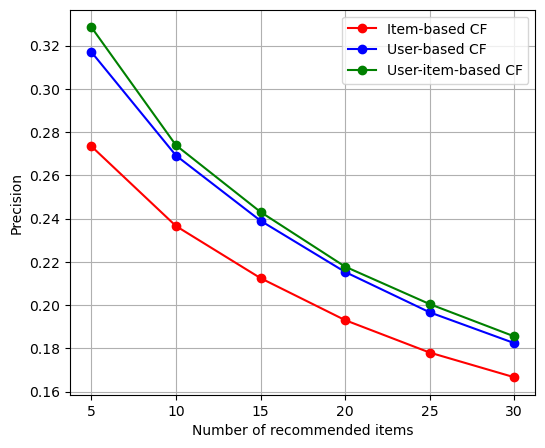

In [9]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, precision_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, precision_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, precision_uibf, label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("Precision")
plt.legend()
plt.show()

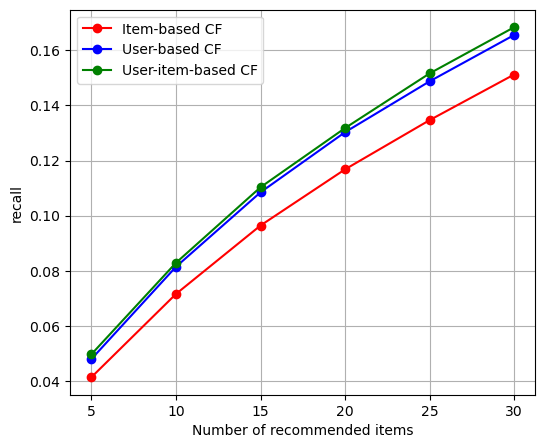

In [10]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, recall_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, recall_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, recall_uibf, label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("recall")
plt.legend()
plt.show()

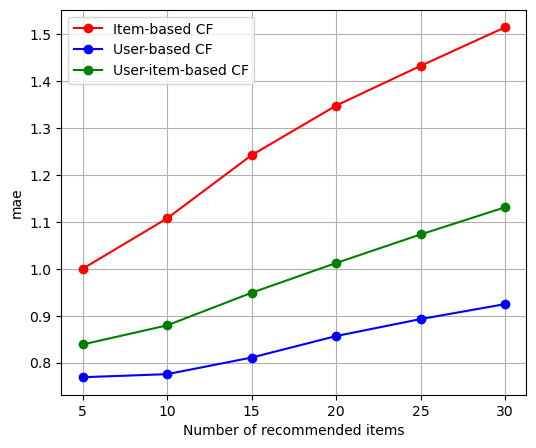

In [11]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf, label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

In [21]:
wht_list = [(i+1)*0.1 for i in range(9)]
n = [5, 10, 15, 20, 25, 30]
precision_uibf = []
recall_uibf = []
mae_uibf = []
for i in wht_list:
    uibf = UserItemBasedCF("ml-latest-small/ratings.csv", wht=i)
    precision_tmp_uibf = []
    recall_tmp_uibf = []
    mae_tmp_uibf = []
    for j in n:
        precision, recall, mae = uibf.evaluate(j)
        precision_tmp_uibf.append(precision)
        recall_tmp_uibf.append(recall)
        mae_tmp_uibf.append(mae)
    precision_uibf.append(precision_tmp_uibf)
    recall_uibf.append(recall_tmp_uibf)
    mae_uibf.append(mae_tmp_uibf)

加载数据...
分割数据...


100%|██████████| 610/610 [00:06<00:00, 99.05it/s] 


为每个用户推荐物品...


100%|██████████| 610/610 [01:27<00:00,  6.94it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
加载数据...
分割数据...


100%|██████████| 610/610 [00:05<00:00, 101.79it/s]


为每个用户推荐物品...


100%|██████████| 610/610 [01:25<00:00,  7.17it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
加载数据...
分割数据...


100%|██████████| 610/610 [00:05<00:00, 104.56it/s]


为每个用户推荐物品...


100%|██████████| 610/610 [01:26<00:00,  7.05it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
加载数据...
分割数据...


100%|██████████| 610/610 [00:06<00:00, 99.91it/s] 


为每个用户推荐物品...


100%|██████████| 610/610 [01:27<00:00,  6.96it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
加载数据...
分割数据...


100%|██████████| 610/610 [00:05<00:00, 103.08it/s]


为每个用户推荐物品...


100%|██████████| 610/610 [01:28<00:00,  6.86it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
加载数据...
分割数据...


100%|██████████| 610/610 [00:05<00:00, 102.34it/s]


为每个用户推荐物品...


100%|██████████| 610/610 [01:26<00:00,  7.07it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
加载数据...
分割数据...


100%|██████████| 610/610 [00:06<00:00, 100.68it/s]


为每个用户推荐物品...


100%|██████████| 610/610 [01:26<00:00,  7.04it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
加载数据...
分割数据...


100%|██████████| 610/610 [00:05<00:00, 101.90it/s]


为每个用户推荐物品...


100%|██████████| 610/610 [01:28<00:00,  6.86it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
加载数据...
分割数据...


100%|██████████| 610/610 [00:06<00:00, 99.51it/s] 


为每个用户推荐物品...


100%|██████████| 610/610 [01:27<00:00,  6.95it/s]


评估模型...
评估模型...
评估模型...
评估模型...
评估模型...
评估模型...


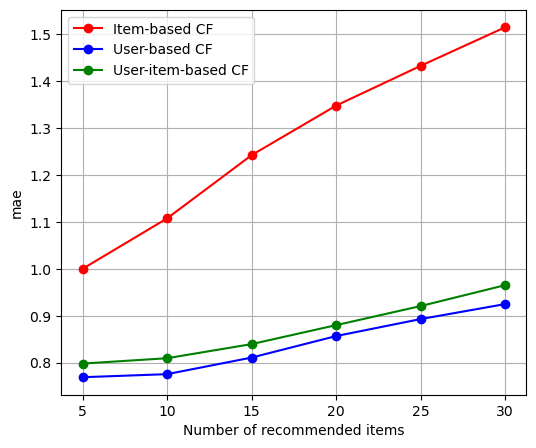

In [22]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[0], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

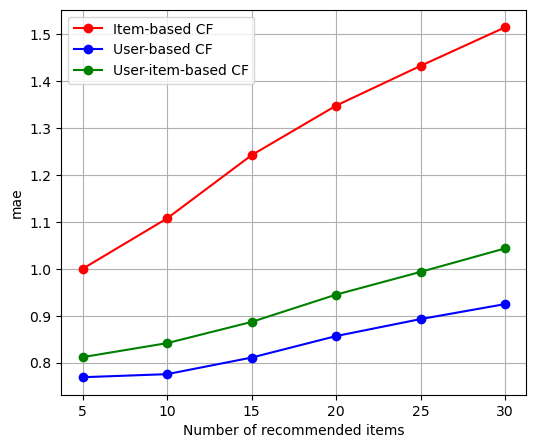

In [23]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[1], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

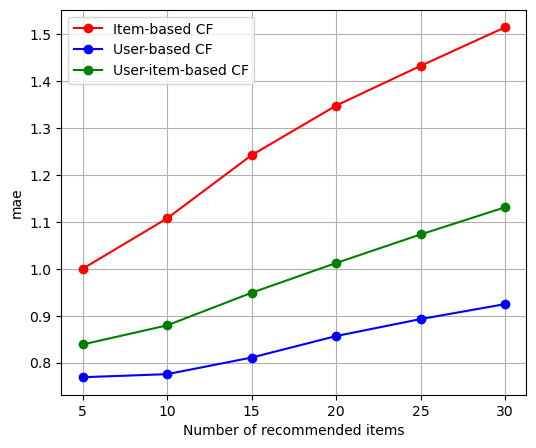

In [24]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[2], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

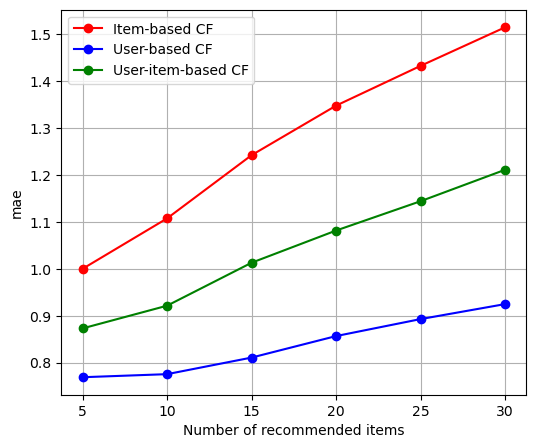

In [25]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[3], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

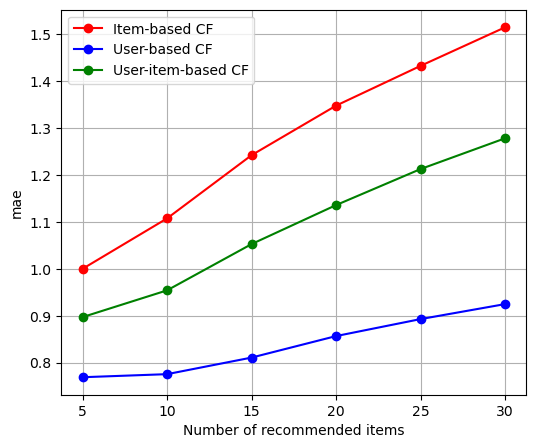

In [26]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[4], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

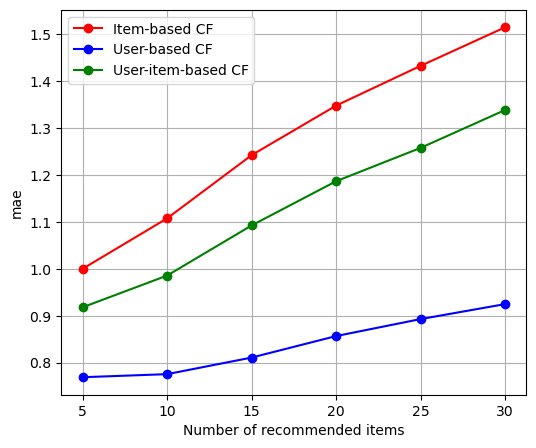

In [27]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[5], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

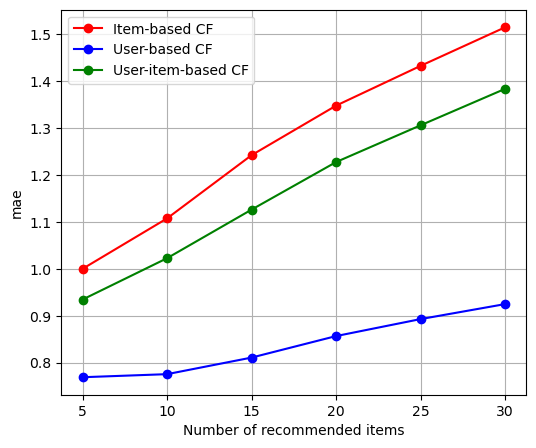

In [28]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[6], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

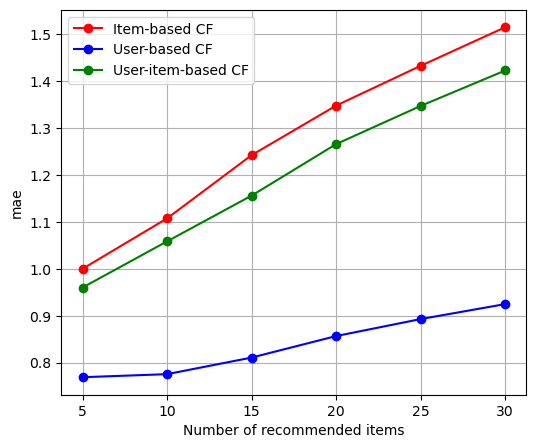

In [29]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[7], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()

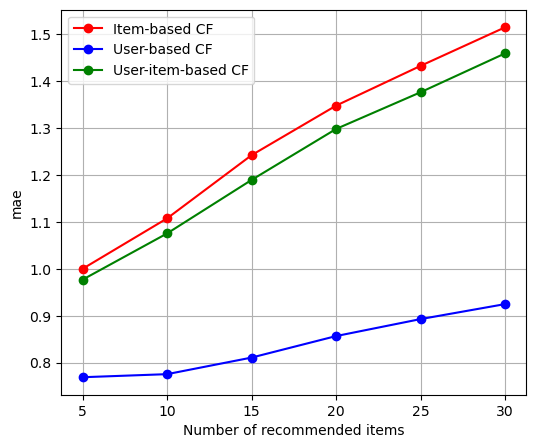

In [30]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n, mae_ibf, label="Item-based CF", color="red", linestyle="-", marker="o")
plt.plot(n, mae_ubf, label="User-based CF", color="blue", linestyle="-", marker="o")
plt.plot(n, mae_uibf[8], label="User-item-based CF", color="green", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("mae")
plt.legend()
plt.show()